# Premier League / FPL Analysis
In this project, we will use data from previously played Premier League football matches to predict the outcome of future games, to calculate various performance related statistics, and to analyse the impact of particular players. It will also attempt to predict the future performances of some players, in particular aiming to help make more informed decision in the 'Fantasy Premier League' (FPL) game.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Ryan\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The following data has been obtained from https://github.com/vaastav/Fantasy-Premier-League. We will use the understat_player file, containing the 'underlying' stats of each player, such as expected goals.

In [2]:
players_us = pd.read_csv('..\\Fantasy-Premier-League-master\\Fantasy-Premier-League-master\\data\\2019-20\\understat\\understat_player.csv')

In [3]:
players_us.head()

,id,player_name,games,time,goals,xG,assists,xA,shots,key_passes,yellow_cards,red_cards,position,team_title,npg,npxG,xGChain,xGBuildup
0,755,Jamie Vardy,26,2224,19,14.239053,4,3.419663,59,16,2,0,F S,Leicester,15,10.433209,13.664330,1.447229
1,318,Pierre-Emerick Aubameyang,26,2309,17,12.001885,1,3.291265,65,20,3,1,F M,Arsenal,16,11.240753,15.131196,4.388375
2,619,Sergio Agüero,22,1407,16,14.949065,3,2.920209,72,19,1,0,F S,Manchester City,14,12.665595,16.170626,2.522262
3,1250,Mohamed Salah,26,2265,16,15.535897,6,7.240067,98,47,1,0,F,Liverpool,13,13.252390,23.791065,6.689903
4,986,Danny Ings,29,2026,15,11.051564,1,1.817600,68,21,2,0,F M S,Southampton,15,11.051564,12.389019,2.437789


In [4]:
players_us.columns

Index(['id', 'player_name', 'games', 'time', 'goals', 'xG', 'assists', 'xA',
       'shots', 'key_passes', 'yellow_cards', 'red_cards', 'position',
       'team_title', 'npg', 'npxG', 'xGChain', 'xGBuildup'],
      dtype='object')

In [5]:
players_us = players_us[['id', 'player_name', 'games', 'goals', 'assists', 'key_passes', 'npg', 'npxG',
       'position', 'red_cards', 'shots', 'team_title', 'time',
       'xA', 'xG', 'xGBuildup', 'xGChain', 'yellow_cards']]

We want to consider the upcoming fixtures, so we will load in the fixtures data from the same folder as the players data. However, the fixtures table contains ID numbers for each team, rather than the team name itself. For clarity, we will replace these with the names of the teams. 
Some players have two teams in their 'team_title' column, most likely if they have gone on loan during the season. Lets fix these first:

In [6]:
for i in players_us[players_us['team_title'].str.contains(',')].index:
    players_us.at[i, 'team_title'] = players_us.at[i, 'team_title'].split(',')[0]

teams = players_us['team_title'].unique()
teams.sort()

array(['Arsenal', 'Aston Villa', 'Bournemouth', 'Brighton', 'Burnley',
       'Chelsea', 'Crystal Palace', 'Everton', 'Leicester', 'Liverpool',
       'Manchester City', 'Manchester United', 'Newcastle United',
       'Norwich', 'Sheffield United', 'Southampton', 'Tottenham',
       'Watford', 'West Ham', 'Wolverhampton Wanderers'], dtype=object)

In [7]:
teams_ser = pd.Series(teams, index=[i+1 for i in range(20)])
fixtures = pd.read_csv('C:\\Users\\Ryan\\Fantasy-Premier-League-master\\Fantasy-Premier-League-master\\data\\2019-20\\fixtures.csv')
fixtures.drop('stats',axis=1,inplace=True)
fixtures['team_h'].replace({i:teams_ser[i] for i in range(1,21)},inplace=True)
fixtures['team_a'].replace({i:teams_ser[i] for i in range(1,21)},inplace=True)
fixtures

,code,event,finished,finished_provisional,id,kickoff_time,minutes,provisional_start_time,started,team_a,team_a_score,team_h,team_h_score,team_h_difficulty,team_a_difficulty
0,1060013,NaN,False,False,311,NaN,0,False,NaN,Norwich,NaN,Arsenal,NaN,2,4
1,1060033,NaN,False,False,331,NaN,0,False,NaN,Leicester,NaN,Arsenal,NaN,3,4
2,1059973,NaN,False,False,271,NaN,0,False,NaN,Sheffield United,NaN,Aston Villa,NaN,3,2
3,1059993,NaN,False,False,291,NaN,0,False,NaN,Chelsea,NaN,Aston Villa,NaN,4,2
4,1060014,NaN,False,False,312,NaN,0,False,NaN,Wolverhampton Wanderers,NaN,Aston Villa,NaN,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,1060077,38.0,False,False,376,2020-05-17T14:00:00Z,0,False,False,Manchester United,NaN,Leicester,NaN,4,3
376,1060078,38.0,False,False,377,2020-05-17T14:00:00Z,0,False,False,Norwich,NaN,Manchester City,NaN,2,4
377,1060079,38.0,False,False,378,2020-05-17T14:00:00Z,0,False,False,Liverpool,NaN,Newcastle United,NaN,4,2
378,1060080,38.0,False,False,379,2020-05-17T14:00:00Z,0,False,False,Sheffield United,NaN,Southampton,NaN,3,2


In [8]:
fixtures = fixtures[['code', 'event', 'finished', 'finished_provisional', 'id',
       'kickoff_time', 'minutes', 'provisional_start_time', 'started',
       'team_h', 'team_h_difficulty', 'team_h_score', 'team_a',
       'team_a_difficulty', 'team_a_score']]

We also want to consider overall team statistics, not just individual player statistics. For this, we will make use of the understat python package, found here: https://github.com/amosbastian/understat, to retrieve data from https://understat.com/league/EPL. 

In [9]:
from understat import Understat

import asyncio

import aiohttp

import json

In [10]:
# async def main():
#     async with aiohttp.ClientSession() as session:
#         understat = Understat(session)
#         teams = await understat.get_teams(
#             "epl",
#             2019
#         )
#         print(json.dumps(teams))

# loop = asyncio.get_event_loop()
# loop.run_until_complete(main())

In [11]:
epl_teams = pd.read_json('c:\\users\\ryan\\19_20_Team_Stats.json', lines=True)

epl_teams = pd.concat([pd.DataFrame(pd.json_normalize(x)) for x in epl_teams['history']], keys=epl_teams['title'])

epl_teams.index.names=['team', 'week']

In [12]:
epl_teams.head()

h_a        xG       xGA      npxG     npxGA  deep  \
team        week                                                     
Aston Villa 0      a  0.639599  2.572620  0.639599  2.572620     2   
            1      h  1.650690  1.627770  1.650690  0.866605    12   
            2      h  0.855926  1.256680  0.855926  1.256680     6   
            3      a  0.303540  1.413940  0.303540  1.413940     5   
            4      h  1.405020  0.535279  1.405020  0.535279     4   

                  deep_allowed  scored  missed    xpts  ...  \
team        week                                        ...   
Aston Villa 0               15       1       3  0.2794  ...   
            1                9       1       2  1.3698  ...   
            2               12       2       0  0.9697  ...   
            3               13       0       1  0.4799  ...   
            4                9       0       0  2.1615  ...   

                                 date wins  draws  loses  pts     npxGD  \
team        week                                                          
Aston Villa 0     2019-08-10 17:30:00    0      0      1    0 -1.933021   
            1     2019-08-17 15:00:00    0      0      1    0  0.784085   
            2     2019-08-23 20:00:00    1      0      0    3 -0.400754   
            3     2019-08-31 15:00:00    0      0      1    0 -1.110400   
            4     2019-09-16 19:00:00    0      1      0    1  0.869741   

                  ppda.att  ppda.def  ppda_allowed.att  ppda_allowed.def  
team        week                                                          
Aston Villa 0          255        19               147                28  
            1          117         9               268                25  
            2          265        20               146                27  
            3          226        25               216                24  
            4          213        22               222                22  

[5 rows x 21 columns]

Note: due to the suspension of the Premier League, there are no games in week 30, so we will do our predictions on gameweek 29 instead. This means we'll have to drop the statistics recorded from the games played in gameweek 29:

In [13]:
epl_teams.drop(28, level='week', inplace=True) 

In [14]:
epl_teams.rename(columns={'loses':'losses', 'missed':'conceded'},inplace=True)
epl_teams = epl_teams.groupby('team').sum()
epl_teams

,xG,xGA,npxG,npxGA,deep,deep_allowed,scored,conceded,xpts,wins,draws,losses,pts,npxGD,ppda.att,ppda.def,ppda_allowed.att,ppda_allowed.def
team,,,,,,,,,,,,,,,,,,
Aston Villa,34.810489,61.467779,32.374001,57.517924,146,282,34,56,23.0312,7,4,17,25,-25.143923,6594,564,5474,686
Everton,46.133930,35.207827,46.133930,34.446660,164,145,37,42,46.3558,10,7,11,37,11.687270,6643,713,6136,588
Bournemouth,32.935891,48.069276,32.174726,45.024598,154,238,28,45,28.2527,7,6,15,27,-12.849872,7457,576,6065,648
Southampton,41.245575,42.085745,39.567925,39.802256,152,180,35,51,41.0387,10,4,14,34,-0.234331,6188,758,5465,560
Leicester,45.359911,36.757552,40.777851,32.190570,224,166,54,28,45.0683,15,5,8,50,8.587281,5660,696,8062,657
Crystal Palace,26.902825,43.388441,24.619315,42.627271,173,218,25,32,28.2108,9,9,10,36,-18.007956,7166,556,5728,718
Norwich,29.769693,52.262960,28.247352,46.781870,173,234,25,51,25.5186,5,6,17,21,-18.534518,6243,538,7126,751
Chelsea,54.062747,30.691631,51.018072,29.169299,253,127,47,39,53.0024,13,6,9,45,21.848773,6201,714,9548,723
West Ham,33.329593,55.722766,31.046084,51.916956,169,226,35,49,23.8038,7,6,15,27,-20.870872,8165,643,5544,620


In [15]:
epl_teams.sort_values('team', inplace=True)
epl_teams.insert(0, 'played', epl_teams['wins'] + epl_teams['draws'] + epl_teams['losses'])
epl_teams = epl_teams[['played', 'wins', 'draws', 'losses', 'scored', 'conceded', 'xG',
       'xGA', 'npxG', 'npxGA', 'npxGD', 'pts', 'xpts']].copy()
epl_teams.insert(8, 'xGD', epl_teams['xG'] - epl_teams['xGA'])
epl_teams.insert(6, 'GD', epl_teams['scored'] - epl_teams['conceded'])

In [16]:
epl_teams

,played,wins,draws,losses,scored,conceded,GD,xG,xGA,xGD,npxG,npxGA,npxGD,pts,xpts
team,,,,,,,,,,,,,,,
Arsenal,28,9,13,6,40,36,4,38.410292,42.428781,-4.018489,36.888002,37.706451,-0.818449,40,37.2599
Aston Villa,28,7,4,17,34,56,-22,34.810489,61.467779,-26.657290,32.374001,57.517924,-25.143923,25,23.0312
Bournemouth,28,7,6,15,28,45,-17,32.935891,48.069276,-15.133385,32.174726,45.024598,-12.849872,27,28.2527
Brighton,28,6,10,12,32,40,-8,38.716444,43.718882,-5.002438,37.955277,42.196542,-4.241265,28,37.5382
Burnley,28,11,5,12,33,39,-6,37.033862,39.390669,-2.356807,35.511522,37.092099,-1.580577,38,36.8343
Chelsea,28,13,6,9,47,39,8,54.062747,30.691631,23.371116,51.018072,29.169299,21.848773,45,53.0024
Crystal Palace,28,9,9,10,25,32,-7,26.902825,43.388441,-16.485616,24.619315,42.627271,-18.007956,36,28.2108
Everton,28,10,7,11,37,42,-5,46.133930,35.207827,10.926103,46.133930,34.446660,11.687270,37,46.3558
Leicester,28,15,5,8,54,28,26,45.359911,36.757552,8.602359,40.777851,32.190570,8.587281,50,45.0683


We now have a dataframe containing information on how each team has performed over the first 28 games. One stat of interest is the 'xpts' stat, meaning 'expected points'. This gives a measure of how many points a team should have based on their other underlying stats. We can use this to see whether a team is over or under-performing by calculating a ratio of points to expected points. Positive numbers show overperformance, negative numbers show underperformance:

In [17]:
epl_teams['performance_ratio'] = epl_teams['pts'] / epl_teams['xpts'] - 1

epl_teams.reset_index(inplace=True)

We can plot this as a bar chart for easier viewing:

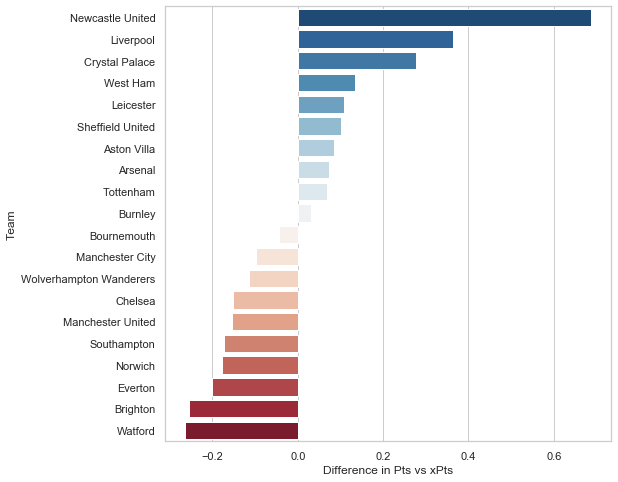

In [18]:
result = epl_teams.sort_values('performance_ratio', ascending=False)
sns.set(style='whitegrid', color_codes=True)
plt.figure(figsize=(8,8))
sns.barplot(x='performance_ratio', y='team', data=result, palette='RdBu_r')
plt.xlabel('Difference in Pts vs xPts')
plt.ylabel('Team');

From this plot it is easy to see that teams like Newcastle, Crystal Palace and Liverpool appear to be overperforming, and have more points than they 'should have' based on stats, whereas Watford, Southampton and Norwich have much fewer points than their stats would suggest. Teams in the middle of the plot, like Tottenham and Wolverhampton, appear to be performing the closest to the level they have been expected to.

We can turn the overall stats into 'per game' stats, which will be more useful for predicting future outcomes:

In [19]:
epl_teams['xGpg'] = epl_teams['xG']/epl_teams['played']
epl_teams['xGApg'] = epl_teams['xGA']/epl_teams['played']

Lets try to predict what the scores will be for the upcoming games (gameweek 29), using the expected goals for and against of each team. Recall the fixtures table:

In [20]:
fixtures

,code,event,finished,finished_provisional,id,kickoff_time,minutes,provisional_start_time,started,team_h,team_h_difficulty,team_h_score,team_a,team_a_difficulty,team_a_score
0,1060013,NaN,False,False,311,NaN,0,False,NaN,Arsenal,2,NaN,Norwich,4,NaN
1,1060033,NaN,False,False,331,NaN,0,False,NaN,Arsenal,3,NaN,Leicester,4,NaN
2,1059973,NaN,False,False,271,NaN,0,False,NaN,Aston Villa,3,NaN,Sheffield United,2,NaN
3,1059993,NaN,False,False,291,NaN,0,False,NaN,Aston Villa,4,NaN,Chelsea,2,NaN
4,1060014,NaN,False,False,312,NaN,0,False,NaN,Aston Villa,4,NaN,Wolverhampton Wanderers,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,1060077,38.0,False,False,376,2020-05-17T14:00:00Z,0,False,False,Leicester,4,NaN,Manchester United,3,NaN
376,1060078,38.0,False,False,377,2020-05-17T14:00:00Z,0,False,False,Manchester City,2,NaN,Norwich,4,NaN
377,1060079,38.0,False,False,378,2020-05-17T14:00:00Z,0,False,False,Newcastle United,4,NaN,Liverpool,2,NaN
378,1060080,38.0,False,False,379,2020-05-17T14:00:00Z,0,False,False,Southampton,3,NaN,Sheffield United,2,NaN


In [21]:
fixtures['kickoff_time'] = pd.to_datetime(fixtures['kickoff_time'])
fixtures['kickoff_time'] = fixtures['kickoff_time'].dt.date
fixtures.rename(columns= {'kickoff_time': 'kickoff_date'}, inplace=True)
fixtures = fixtures[['code', 'event',  'id',
       'kickoff_date',
       'team_h', 'team_h_difficulty', 'team_h_score', 'team_a',
       'team_a_difficulty', 'team_a_score']].copy()

fixtures = fixtures[pd.notnull(fixtures['kickoff_date'])].copy()
fixtures.rename(columns={'event':'week'},inplace=True)

We are interested in the gameweek 29 fixtures:

In [22]:
fixtures_gw_29 = fixtures[fixtures['week'] == 29]
fixtures_gw_29

,code,week,id,kickoff_date,team_h,team_h_difficulty,team_h_score,team_a,team_a_difficulty,team_a_score
340,1059987,29.0,286,2020-03-07,Liverpool,2,2.0,Bournemouth,5,1.0
341,1059982,29.0,281,2020-03-07,Arsenal,2,1.0,West Ham,4,0.0
342,1059985,29.0,284,2020-03-07,Crystal Palace,2,1.0,Watford,3,0.0
343,1059989,29.0,288,2020-03-07,Sheffield United,2,1.0,Norwich,3,0.0
344,1059990,29.0,289,2020-03-07,Southampton,2,0.0,Newcastle United,2,1.0
345,1059991,29.0,290,2020-03-07,Wolverhampton Wanderers,2,0.0,Brighton,3,0.0
346,1059983,29.0,282,2020-03-07,Burnley,3,1.0,Tottenham,3,1.0
347,1059984,29.0,283,2020-03-08,Chelsea,2,4.0,Everton,4,0.0
348,1059988,29.0,287,2020-03-08,Manchester United,4,2.0,Manchester City,4,0.0
349,1059986,29.0,285,2020-03-09,Leicester,2,4.0,Aston Villa,3,0.0


Now lets join the underlying stats data for both teams in each match:

In [23]:
fixtures_gw_29 = pd.merge(fixtures_gw_29, epl_teams, left_on='team_h', right_on='team')

fixtures_gw_29 = fixtures_gw_29[['code', 'week', 'id', 'kickoff_date', 'team_h', 'team_h_difficulty',
        'team_a', 'team_a_difficulty', 'xGpg', 'xGApg']]

fixtures_gw_29.rename(columns={'xGpg': 'xGpg_h', 'xGApg': 'xGApg_h'}, inplace=True)

fixtures_gw_29 = pd.merge(fixtures_gw_29, epl_teams, left_on = 'team_a', right_on='team')

fixtures_gw_29.rename(columns={'xGpg': 'xGpg_a', 'xGApg': 'xGApg_a'}, inplace=True)

fixtures_gw_29 = fixtures_gw_29[['code', 'week', 'id', 'kickoff_date', 'team_h', 'team_h_difficulty',
       'team_a', 'team_a_difficulty', 'xGpg_h', 'xGApg_h',
       'xGpg_a', 'xGApg_a']]

fixtures_gw_29

,code,week,id,kickoff_date,team_h,team_h_difficulty,team_a,team_a_difficulty,xGpg_h,xGApg_h,xGpg_a,xGApg_a
0,1059987,29.0,286,2020-03-07,Liverpool,2,Bournemouth,5,2.111897,0.978355,1.176282,1.716760
1,1059982,29.0,281,2020-03-07,Arsenal,2,West Ham,4,1.371796,1.515314,1.190343,1.990099
2,1059985,29.0,284,2020-03-07,Crystal Palace,2,Watford,3,0.960815,1.549587,1.310594,1.549269
3,1059989,29.0,288,2020-03-07,Sheffield United,2,Norwich,3,1.308829,1.317083,1.063203,1.866534
4,1059990,29.0,289,2020-03-07,Southampton,2,Newcastle United,2,1.473056,1.503062,0.816257,1.856601
5,1059991,29.0,290,2020-03-07,Wolverhampton Wanderers,2,Brighton,3,1.561655,1.107121,1.382730,1.561389
6,1059983,29.0,282,2020-03-07,Burnley,3,Tottenham,3,1.322638,1.406810,1.373453,1.474613
7,1059984,29.0,283,2020-03-08,Chelsea,2,Everton,4,1.930812,1.096130,1.647640,1.257422
8,1059988,29.0,287,2020-03-08,Manchester United,4,Manchester City,4,1.690144,1.070648,2.609960,0.995191
9,1059986,29.0,285,2020-03-09,Leicester,2,Aston Villa,3,1.619997,1.312770,1.243232,2.195278


We could use these stats for our predictions, however remember that we obtained these 'per game' stats by taking the averages over all games played so far this season, including both home and away games. We want to account for whether a team is playing at home or away in each match, as it has historically had an effect on the outcome of games. To quantify the effect playing at home has, we can use the data from last season to see how many more goals teams score on average when playing at home compared to playing away:

In [24]:
fixtures_18_19 = pd.read_csv('C:\\Users\\Ryan\\Fantasy-Premier-League-master\\Fantasy-Premier-League-master\\data\\2018-19\\fixtures.csv')

In [25]:
fixtures_18_19 = fixtures_18_19[['code','event',
       'event_day','id',
       'minutes',
       'team_a', 'team_a_difficulty', 'team_a_score',
       'team_h', 'team_h_difficulty', 'team_h_score']]

In [26]:
fixtures_18_19

,code,event,event_day,id,minutes,team_a,team_a_difficulty,team_a_score,team_h,team_h_difficulty,team_h_score
0,987597,1,1,6,90,11,4,1,14,3,2
1,987598,1,2,7,90,17,3,2,15,4,1
2,987592,1,2,2,90,5,3,0,2,2,2
3,987594,1,2,3,90,7,2,2,9,2,0
4,987595,1,2,4,90,6,2,3,10,4,0
...,...,...,...,...,...,...,...,...,...,...,...
375,987967,38,1,376,90,20,5,0,12,3,2
376,987968,38,1,377,90,5,4,2,14,2,0
377,987969,38,1,378,90,10,2,1,16,2,1
378,987970,38,1,379,90,8,4,2,17,2,2


In [27]:
home_adj = np.round((fixtures_18_19['team_h_score'].sum()/380)/((fixtures_18_19['team_h_score'].sum() + fixtures_18_19['team_a_score'].sum()) / (380*2)), 4)

away_adj = np.round((fixtures_18_19['team_a_score'].sum()/380)/((fixtures_18_19['team_h_score'].sum() + fixtures_18_19['team_a_score'].sum()) / (380*2)), 4)

home_adj, away_adj

(1.1119, 0.8881)

From this we see that, on average, teams score 1.1x more goals when playing at home, and 0.89x times the amount of goals when playing away. We can use these numbers in combination with the expected goals for and against for each team to modify the predicted scorelines:

In [28]:
xGpg_avg = epl_teams['xGpg'].mean()

fixtures_gw_29['xG_adj_h'] = ((fixtures_gw_29['xGpg_h']*fixtures_gw_29['xGApg_a'])/xGpg_avg)*home_adj

fixtures_gw_29['xG_adj_a'] = ((fixtures_gw_29['xGpg_a']*fixtures_gw_29['xGApg_h'])/xGpg_avg)*away_adj

In [29]:
scores_gw_29 = fixtures_gw_29[['team_h', 'team_a','xG_adj_h', 'xG_adj_a']]

scores_gw_29.round()

,team_h,team_a,xG_adj_h,xG_adj_a
0,Liverpool,Bournemouth,3.0,1.0
1,Arsenal,West Ham,2.0,1.0
2,Crystal Palace,Watford,1.0,1.0
3,Sheffield United,Norwich,2.0,1.0
4,Southampton,Newcastle United,2.0,1.0
5,Wolverhampton Wanderers,Brighton,2.0,1.0
6,Burnley,Tottenham,1.0,1.0
7,Chelsea,Everton,2.0,1.0
8,Manchester United,Manchester City,1.0,2.0
9,Leicester,Aston Villa,3.0,1.0


This dataframe gives our initial predicted scores for gameweek 29, based on in-game statistics recorded in the 28 previous games from this season. These predictions are not as detailed as they could be, for example they fail to take into account many external factors which could affect performance, such as injuries to key players or managerial changes, however these factors can be harder to quantify. 

Is considering all previous weeks the best way to make predictions? We may expect that a more accurate prediction could be made by only considering a teams 'current form', in other words only taking into account statistics gathered from more recent games. We can use the non-aggregated team stats for this:

In [30]:
grouped_teams = pd.read_json('..\\19_20_Team_Stats.json', lines=True)

grouped_teams = pd.concat([pd.DataFrame(pd.json_normalize(x)) for x in grouped_teams['history']], keys=grouped_teams['title'])

grouped_teams.index.names=['team', 'week']

We are only interested in the xG and xGA data:

In [31]:
grouped_teams = grouped_teams[['h_a', 'date', 'xG', 'xGA']]
grouped_teams['date'] = pd.to_datetime(grouped_teams['date'])
grouped_teams['date'] = grouped_teams['date'].dt.date
grouped_teams.reset_index(inplace=True)
grouped_teams['week'] = grouped_teams['week'] + 1
grouped_teams.set_index(['team', 'week'], inplace=True)

We can write a function which will output a dataframe containing our predictions for the upcoming gameweek, but only considering a specified number of previous weeks results:

In [32]:
def predict_scores(week, prev_weeks, fixture_df, teams_df):
    a = []
    for i in range(week-1, week-prev_weeks-1, -1):
        a.append(i)
    idx = pd.IndexSlice
    df = fixture_df[fixture_df['week'] == week]
    temp_df = teams_df.loc[idx[:,a], :]
    temp_df = temp_df.groupby('team').sum()
    temp_df /= prev_weeks
    df = pd.merge(df, temp_df, left_on = 'team_h', right_on='team')
    df = pd.merge(df, temp_df, left_on = 'team_a', right_on='team')
    
    xGpg_avg = temp_df['xG'].mean()
    df['xG_x_adj'] = ((df['xG_x']*df['xGA_y'])/xGpg_avg)*home_adj
    df['xG_y_adj'] = ((df['xG_y']*df['xGA_x'])/xGpg_avg)*away_adj
    df = df[['team_h', 'team_a', 'xG_x_adj', 'xG_y_adj']]
    df = df.round()
    df.rename(columns={'xG_x_adj':'home score', 'xG_y_adj': 'away score'}, inplace=True)
    return(df)   

To test if this function works, lets try to predict the scores for gameweek 29 using all 28 previous weeks:

In [33]:
test = predict_scores(29, 28, fixtures, grouped_teams)
test

,team_h,team_a,home score,away score
0,Liverpool,Bournemouth,3.0,1.0
1,Arsenal,West Ham,2.0,1.0
2,Crystal Palace,Watford,1.0,1.0
3,Sheffield United,Norwich,2.0,1.0
4,Southampton,Newcastle United,2.0,1.0
5,Wolverhampton Wanderers,Brighton,2.0,1.0
6,Burnley,Tottenham,1.0,1.0
7,Chelsea,Everton,2.0,1.0
8,Manchester United,Manchester City,1.0,2.0
9,Leicester,Aston Villa,3.0,1.0


We can see this dataframe is identical to the one we found previously. Using this function, we can get a better idea of how many previous weeks should be taken into account for the most accurate predictions. For example, only considering last weeks results to be relevant:

In [34]:
one_week = predict_scores(29, 1, fixtures, grouped_teams)
one_week

,team_h,team_a,home score,away score
0,Liverpool,Bournemouth,0.0,3.0
1,Arsenal,West Ham,1.0,3.0
2,Crystal Palace,Watford,0.0,3.0
3,Sheffield United,Norwich,1.0,1.0
4,Southampton,Newcastle United,0.0,2.0
5,Wolverhampton Wanderers,Brighton,4.0,2.0
6,Burnley,Tottenham,1.0,1.0
7,Chelsea,Everton,2.0,2.0
8,Manchester United,Manchester City,1.0,1.0
9,Leicester,Aston Villa,3.0,0.0


We can test which number of previous weeks gives the most accurate outcomes by using the prediction function on data from previous seasons. For example, let's use the 18/19 season. We will need the scores from each game, which we can obtain via web scraping:

In [35]:
import requests
from bs4 import BeautifulSoup

In [36]:
source = requests.get('http://fbref.com/en/comps/9/1889/schedule/2018-2019-Premier-League-Fixtures').text
soup = BeautifulSoup(source, 'lxml')

table = soup.find('table')
table_rows = table.find_all('tr')
l = []

for tr in table_rows:
    th = tr.find_all('th')
    td = tr.find_all('td')
    row = [t.text for t in th] + [t.text for t in td if t.text != '']
    l.append(row)
    
stats_1819 = pd.DataFrame(l)
stats_1819.dropna(thresh=12, inplace=True)

header = stats_1819.iloc[0]

stats_1819 = stats_1819[1:]
stats_1819.columns = header
stats_1819['Wk'] = stats_1819['Wk'].astype('int32')
stats_1819.columns = ['Wk', 'Day', 'Date', 'Time', 'Home', 'xG_h', 'Score', 'xG_a', 'Away',
       'Attendance', 'Venue', 'Referee', 'Match Report', 'Notes']

In [37]:
stats_1819 = stats_1819[['Wk', 'Home', 'xG_h', 'Score', 'xG_a', 'Away']]

stats_1819.replace({'Home':{'Manchester Utd':'Manchester United', 'Leicester City': 'Leicester', 'Cardiff City':'Cardiff', 
                            'Wolves': 'Wolverhampton Wanderers', 'Newcastle Utd': 'Newcastle United'},
                    'Away':{'Manchester Utd':'Manchester United', 'Leicester City': 'Leicester', 'Cardiff City':'Cardiff', 
                            'Wolves': 'Wolverhampton Wanderers', 'Newcastle Utd': 'Newcastle United'}}, inplace=True)

stats_1819.rename(columns={'Home':'team_h', 'Away':'team_a', 'Wk': 'week'}, inplace=True)
stats_1819.drop(['xG_h', 'xG_a'], axis=1, inplace=True)
stats_1819['home score'] = stats_1819['Score'].str[0].astype('float64')
stats_1819['away score'] = stats_1819['Score'].str[2].astype('float64')
stats_1819.drop('Score', axis=1, inplace=True)

scores_1819 = stats_1819 
scores_1819

,week,team_h,team_a,home score,away score
1,1,Manchester United,Leicester,2.0,1.0
2,1,Newcastle United,Tottenham,1.0,2.0
3,1,Huddersfield,Chelsea,0.0,3.0
4,1,Fulham,Crystal Palace,0.0,2.0
5,1,Watford,Brighton,2.0,0.0
...,...,...,...,...,...
421,38,Tottenham,Everton,2.0,2.0
422,38,Watford,West Ham,1.0,4.0
423,38,Manchester United,Cardiff,0.0,2.0
424,38,Southampton,Huddersfield,1.0,1.0


Now we have all the results from the last season, we need the xG stats for each game, which we'll again use the understat package for.

In [38]:
grouped_teams_1819 = pd.read_json('..\\18_19_team_stats.json', lines=True)
grouped_teams_1819 = pd.concat([pd.DataFrame(pd.json_normalize(x)) for x in grouped_teams_1819['history']], keys=grouped_teams_1819['title'])
grouped_teams_1819.index.names=['team', 'week']
grouped_teams_1819 = grouped_teams_1819[['h_a', 'date', 'xG', 'xGA']]
grouped_teams_1819.reset_index(inplace=True)
grouped_teams_1819['week'] = grouped_teams_1819['week'] + 1
grouped_teams_1819.set_index(['team', 'week'], inplace=True)

grouped_teams_1819

h_a                 date        xG       xGA
team                    week                                             
Everton                 1      a  2018-08-11 19:30:00  0.715382  0.891038
                        2      h  2018-08-18 17:00:00  2.020040  1.774710
                        3      a  2018-08-25 17:00:00  0.543665  2.588700
                        4      h  2018-09-01 14:00:00  0.616013  0.660035
                        5      h  2018-09-16 15:00:00  1.267740  1.524370
...                           ..                  ...       ...       ...
Wolverhampton Wanderers 34     h  2019-04-20 15:00:00  2.604470  0.115051
                        35     h  2019-04-24 19:45:00  0.982018  0.939754
                        36     a  2019-04-27 15:00:00  2.443570  0.896093
                        37     h  2019-05-04 14:00:00  2.093970  0.512477
                        38     a  2019-05-12 14:00:00  0.883861  1.701970

[760 rows x 4 columns]

Now we have both the expected goals stats and the actual scores for each game, we can use the prediction function to create a dataframe of predicted scores, and compare it to the actual scores. We want to test how many previous weeks of stats produces the most accurate scorelines. To do this, we'll need to loop over a range of values for prev_weeks in the function, and also loop over a range of gameweeks to increase our sample size (note however we must start from week 9 here, as this is the first week for which our largest tested value, 8 weeks, has enough previous data to work with):

In [39]:
accuracy_1819 = pd.DataFrame({('gameweek ' + str(i)): ((predict_scores(i,j, scores_1819, grouped_teams_1819)[['home score', 'away score']]
                                                        == scores_1819[scores_1819['week']==i].reset_index(drop=True)[['home score', 'away score']])
                                                       .sum().sum())/20 for i in range(9,38)} for j in range(1,9))
accuracy_1819.index = range(1, len(accuracy_1819)+1)
accuracy_1819

,gameweek 9,gameweek 10,gameweek 11,gameweek 12,gameweek 13,gameweek 14,gameweek 15,gameweek 16,gameweek 17,gameweek 18,...,gameweek 28,gameweek 29,gameweek 30,gameweek 31,gameweek 32,gameweek 33,gameweek 34,gameweek 35,gameweek 36,gameweek 37
1,0.20,0.45,0.15,0.30,0.20,0.20,0.35,0.25,0.60,0.30,...,0.25,0.35,0.35,0.25,0.40,0.50,0.15,0.30,0.15,0.35
2,0.30,0.40,0.25,0.50,0.20,0.35,0.45,0.40,0.55,0.10,...,0.20,0.25,0.25,0.45,0.20,0.45,0.30,0.30,0.30,0.45
3,0.25,0.35,0.35,0.50,0.15,0.35,0.40,0.25,0.50,0.20,...,0.35,0.30,0.35,0.30,0.50,0.35,0.45,0.35,0.35,0.35
4,0.30,0.25,0.45,0.55,0.20,0.40,0.55,0.25,0.55,0.25,...,0.25,0.40,0.35,0.25,0.40,0.40,0.35,0.40,0.35,0.25
5,0.30,0.40,0.30,0.55,0.15,0.30,0.50,0.30,0.50,0.35,...,0.35,0.25,0.25,0.35,0.35,0.30,0.25,0.25,0.25,0.35
6,0.35,0.35,0.25,0.55,0.15,0.45,0.60,0.35,0.45,0.30,...,0.25,0.25,0.25,0.35,0.35,0.30,0.20,0.45,0.35,0.30
7,0.35,0.35,0.35,0.50,0.10,0.45,0.55,0.25,0.45,0.30,...,0.35,0.15,0.20,0.45,0.25,0.40,0.20,0.30,0.40,0.25
8,0.25,0.40,0.35,0.45,0.15,0.45,0.60,0.25,0.50,0.35,...,0.35,0.15,0.25,0.50,0.30,0.35,0.25,0.45,0.40,0.20


The dataframe above contains the accuracy of our prediction model to the actual results for each week, where the indexed number on the left represents how many previous weeks were considered when making the predictions. We can now take the average of each row to get an overall percentage:

In [40]:
accuracy_percentages_1819 = accuracy_1819.mean(axis=1)
accuracy_percentages_1819.index.name = 'No. of previous weeks'
accuracy_percentages_1819 = round(accuracy_percentages_1819 * 100, 1)

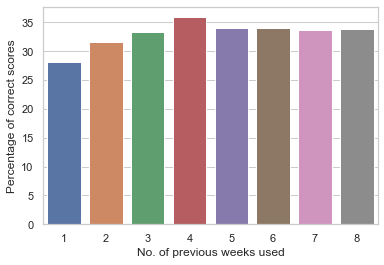

In [41]:
sns.barplot(accuracy_percentages_1819.index, accuracy_percentages_1819.values)
plt.xlabel('No. of previous weeks used')
plt.ylabel('Percentage of correct scores');

We see that using four weeks of stats seems to provide the most accurate predictions, although the model is relatively close for all values greater than 1. This is using a fairly small sample size however - we could import data from earlier seasons and combine the percentages together for a better estimate, but for now we'll assume four weeks is the best.

We'll now turn our attention to the FPL game. Lets load some player data from www.fplanalytics.com:

In [42]:
fpl = pd.read_csv('..\\FPL_1920_players.csv')

In [43]:
fpl

,name,team,position,cost,status,minutes,total_points,bonus,points_per_game,selected_by_percent
0,Mustafi,ARS,DEF,5.2,Available,0,0,0,0.0,0.4
1,Bellerín,ARS,DEF,5.4,Available,0,0,0,0.0,0.3
2,Kolasinac,ARS,DEF,5.4,Available,577,18,1,2.0,0.8
3,Maitland-Niles,ARS,DEF,4.8,Available,490,17,3,2.8,3.5
4,Sokratis,ARS,DEF,5.0,Available,990,31,2,2.8,2.0
...,...,...,...,...,...,...,...,...,...,...
552,Vallejo,WOL,DEF,4.7,Available,162,1,0,0.5,0.3
553,Cutrone,WOL,FWD,5.6,Available,279,15,0,1.9,0.6
554,Neto,WOL,MID,5.0,Available,135,9,0,1.3,0.0
555,Ashley-Seal,WOL,FWD,4.5,Available,0,0,0,0.0,0.0


We want to perform some analysis on which players are the best picks for the upcoming gameweeks, through a combination of the fpl data and the underlying stats data.

In [44]:
players_us.insert(2, 'fpl_name', players_us['player_name'])

In [45]:
for row in range(players_us.shape[0]):
    if len(players_us.at[row, 'player_name'].split(' ')) == 1:
        players_us.at[row, 'fpl_name'] = players_us.at[row, 'player_name']
    else:
        players_us.at[row, 'fpl_name'] = players_us.at[row, 'player_name'].split(' ')[1]

players_us.at[17, 'fpl_name'] = 'De Bruyne'
players_us.at[18, 'fpl_name'] = 'Son'
players_us.at[43, 'fpl_name'] = 'B. Silva'
players_us.at[59, 'fpl_name'] = 'El Ghazi'
players_us.at[103, 'fpl_name'] = 'D.Silva'

Lets create two new columns in our players table, called Goal Involvement (GI) and Expected Goal Involvement. We can filter the table by players with at least 10 GI, considering forwards first:

In [46]:
players_us['GI'] = players_us['goals'] + players_us['assists']
players_us['xGI'] = players_us['xG'] + players_us['xA']
players_us.head()

,id,player_name,fpl_name,games,goals,assists,key_passes,npg,npxG,position,...,shots,team_title,time,xA,xG,xGBuildup,xGChain,yellow_cards,GI,xGI
0,755,Jamie Vardy,Vardy,26,19,4,16,15,10.433209,F S,...,59,Leicester,2224,3.419663,14.239053,1.447229,13.664330,2,23,17.658717
1,318,Pierre-Emerick Aubameyang,Aubameyang,26,17,1,20,16,11.240753,F M,...,65,Arsenal,2309,3.291265,12.001885,4.388375,15.131196,3,18,15.293150
2,619,Sergio Agüero,Agüero,22,16,3,19,14,12.665595,F S,...,72,Manchester City,1407,2.920209,14.949065,2.522262,16.170626,1,19,17.869274
3,1250,Mohamed Salah,Salah,26,16,6,47,13,13.252390,F,...,98,Liverpool,2265,7.240067,15.535897,6.689903,23.791065,1,22,22.775964
4,986,Danny Ings,Ings,29,15,1,21,15,11.051564,F M S,...,68,Southampton,2026,1.817600,11.051564,2.437789,12.389019,2,16,12.869164


In [47]:
players_us_GI10 = players_us[players_us['GI'] >=10].copy()
players_us_GI10

,id,player_name,fpl_name,games,goals,assists,key_passes,npg,npxG,position,...,shots,team_title,time,xA,xG,xGBuildup,xGChain,yellow_cards,GI,xGI
0,755,Jamie Vardy,Vardy,26,19,4,16,15,10.433209,F S,...,59,Leicester,2224,3.419663,14.239053,1.447229,13.664330,2,23,17.658717
1,318,Pierre-Emerick Aubameyang,Aubameyang,26,17,1,20,16,11.240753,F M,...,65,Arsenal,2309,3.291265,12.001885,4.388375,15.131196,3,18,15.293150
2,619,Sergio Agüero,Agüero,22,16,3,19,14,12.665595,F S,...,72,Manchester City,1407,2.920209,14.949065,2.522262,16.170626,1,19,17.869274
3,1250,Mohamed Salah,Salah,26,16,6,47,13,13.252390,F,...,98,Liverpool,2265,7.240067,15.535897,6.689903,23.791065,1,22,22.775964
4,986,Danny Ings,Ings,29,15,1,21,15,11.051564,F M S,...,68,Southampton,2026,1.817600,11.051564,2.437789,12.389019,2,16,12.869164
5,556,Marcus Rashford,Rashford,22,14,4,24,9,9.782330,F M,...,74,Manchester United,1890,3.204604,15.110475,2.935295,12.892827,2,18,18.315079
6,838,Sadio Mané,Mané,26,14,7,41,14,12.425494,F M S,...,60,Liverpool,2090,4.868996,12.425494,5.027967,19.738065,2,21,17.294489
7,702,Tammy Abraham,Abraham,25,13,3,20,13,13.400192,F S,...,73,Chelsea,1976,2.852206,13.400192,0.963469,15.391332,2,16,16.252399
8,4105,Raúl Jiménez,Jiménez,29,13,6,42,10,11.627585,F S,...,98,Wolverhampton Wanderers,2473,6.644597,13.911092,4.716690,19.596093,3,19,20.555689
9,5555,Dominic Calvert-Lewin,Calvert-Lewin,27,13,1,14,13,14.147039,F S,...,65,Everton,1919,1.216507,14.147039,3.410178,15.353524,7,14,15.363546


In [48]:
fpl_fw_filter = fpl[fpl['position'] == 'FWD'].copy()
forwards = players_us_GI10[players_us_GI10['fpl_name'].isin(fpl_fw_filter['name']) | players_us_GI10['player_name'].isin(fpl_fw_filter['name'])].copy()
forwards.reset_index(inplace=True, drop=True)
forwards

,id,player_name,fpl_name,games,goals,assists,key_passes,npg,npxG,position,...,shots,team_title,time,xA,xG,xGBuildup,xGChain,yellow_cards,GI,xGI
0,755,Jamie Vardy,Vardy,26,19,4,16,15,10.433209,F S,...,59,Leicester,2224,3.419663,14.239053,1.447229,13.664330,2,23,17.658717
1,318,Pierre-Emerick Aubameyang,Aubameyang,26,17,1,20,16,11.240753,F M,...,65,Arsenal,2309,3.291265,12.001885,4.388375,15.131196,3,18,15.293150
2,619,Sergio Agüero,Agüero,22,16,3,19,14,12.665595,F S,...,72,Manchester City,1407,2.920209,14.949065,2.522262,16.170626,1,19,17.869274
3,986,Danny Ings,Ings,29,15,1,21,15,11.051564,F M S,...,68,Southampton,2026,1.817600,11.051564,2.437789,12.389019,2,16,12.869164
4,556,Marcus Rashford,Rashford,22,14,4,24,9,9.782330,F M,...,74,Manchester United,1890,3.204604,15.110475,2.935295,12.892827,2,18,18.315079
5,702,Tammy Abraham,Abraham,25,13,3,20,13,13.400192,F S,...,73,Chelsea,1976,2.852206,13.400192,0.963469,15.391332,2,16,16.252399
6,4105,Raúl Jiménez,Jiménez,29,13,6,42,10,11.627585,F S,...,98,Wolverhampton Wanderers,2473,6.644597,13.911092,4.716690,19.596093,3,19,20.555689
7,5555,Dominic Calvert-Lewin,Calvert-Lewin,27,13,1,14,13,14.147039,F S,...,65,Everton,1919,1.216507,14.147039,3.410178,15.353524,7,14,15.363546
8,647,Harry Kane,Kane,20,11,2,20,9,6.375230,F,...,57,Tottenham,1785,1.958417,7.897531,2.426382,10.012867,2,13,9.855948
9,4456,Chris Wood,Wood,26,11,1,18,11,14.472395,F S,...,53,Burnley,2083,0.761408,14.472395,2.299790,10.519814,1,12,15.233803


Lets consider whether these players has been 'overperforming' so far in terms of goal involvement, by comparing their expected involvement to their actual involvement. We'll also include data from previous seasons to see how this season compares:

In [49]:
_1819 = pd.read_json('..\\players_18_19.json', lines=True)
_1718 = pd.read_json('..\\players_17_18.json', lines=True)

_1819['GI'] = _1819['goals'] + _1819['assists']
_1819['xGI'] = _1819['xG'] + _1819['xA']

_1718['GI'] = _1718['goals'] + _1718['assists']
_1718['xGI'] = _1718['xG'] + _1718['xA']

_1819_fw = _1819[_1819['player_name'].isin(list(forwards['player_name']))]
_1718_fw = _1718[_1718['player_name'].isin(list(forwards['player_name']))]

We can make some graphs to help visualise the players' performance, plotting expected goals against goals. We'll produce a seperate graph for each seasons' data (making use of the adjustText package found at http://github.com/Phlya/adjustText ):

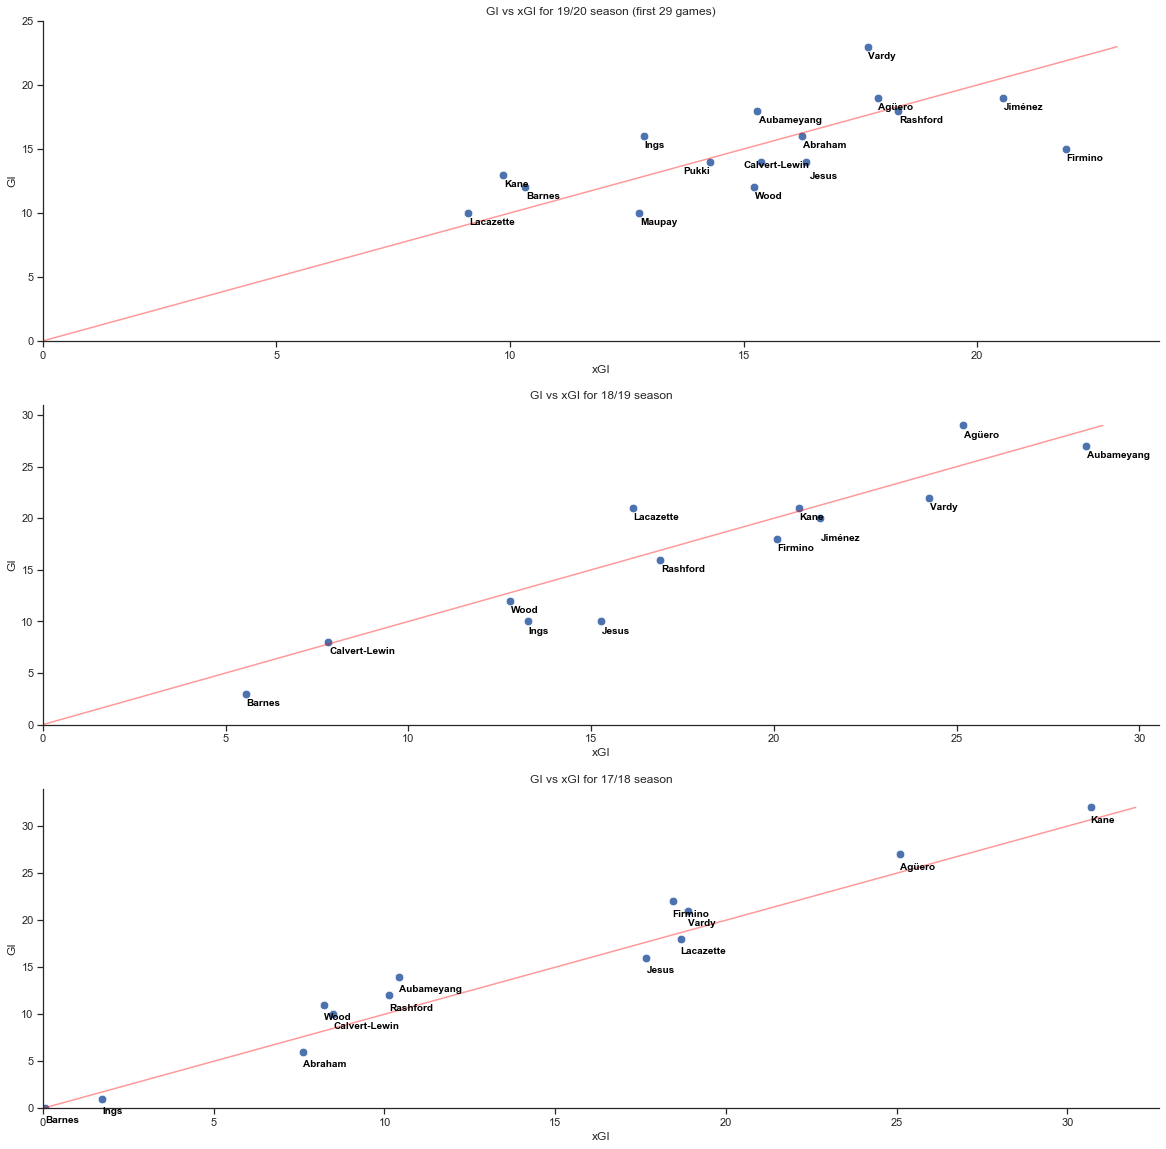

In [50]:
from adjustText import adjust_text
sns.set_style('white')
sns.set_style('ticks')
fig, ax = plt.subplots(3, figsize=(20,20))
dfs = [forwards, _1819_fw, _1718_fw]
for index, df in enumerate(dfs):
    ax[index].set_xlim(0,max(df['xGI'])+2)
    ax[index].set_ylim(0,max(df['GI'])+2)
    sns.lineplot(x=[0,max(max(df['GI']), max(df['xGI']))], y=[0,max(max(df['GI']), max(df['xGI']))], 
                 data=df, color='red', alpha=0.4, ax=ax[index])
    sns.scatterplot(x='xGI', y='GI', data=df, s=75, ax=ax[index])
    sns.despine()
    texts = []
    for row in range(df.shape[0]):
        if len(df.iloc[row]['player_name'].split(' ')) > 1:
            texts.append(ax[index].text(df.iloc[row]['xGI'], df.iloc[row]['GI']-0.05*max(df['GI']), df.iloc[row]['player_name'].split(' ')[1],
                            size='small', color='black', weight='semibold')),
        else:
            texts.append(ax[index].text(df.iloc[row]['xGI'], df.iloc[row]['GI']-0.05*max(df['GI']), df.iloc[row]['player_name'],
                            size='small', color='black', weight='semibold'))
    if index <= 1:
        adjust_text(texts, ax=ax[index])

ax[0].set_title('GI vs xGI for 19/20 season (first 29 games)')
ax[1].set_title('GI vs xGI for 18/19 season')
ax[2].set_title('GI vs xGI for 17/18 season');

These graphs show the level of over or underperformance each season. Note that not all players being considered from this season were playing in the premier league in previous years. The red line indicates a 1:1 ratio of expected GI to actual GI.
This season, we can see that Vardy is significantly outperforming his stats, whereas players such as Wood and Firmino are underperforming.

The previous seasons results show that players tend to perform very close to their expected performance, so we can expect the outliers for this season to move closer to the expected range.

Lets produce similar graphs for midfielders:

In [51]:
fpl_mid_filter = fpl[(fpl['position'] == 'MID')].copy()
midfielders = players_us_GI10[players_us_GI10['fpl_name'].isin(fpl_mid_filter['name']) | players_us_GI10['player_name'].isin(fpl_mid_filter['name'])].copy()
midfielders.reset_index(inplace=True, drop=True)
midfielders

,id,player_name,fpl_name,games,goals,assists,key_passes,npg,npxG,position,...,shots,team_title,time,xA,xG,xGBuildup,xGChain,yellow_cards,GI,xGI
0,1250,Mohamed Salah,Salah,26,16,6,47,13,13.252390,F,...,98,Liverpool,2265,7.240067,15.535897,6.689903,23.791065,1,22,22.775964
1,838,Sadio Mané,Mané,26,14,7,41,14,12.425494,F M S,...,60,Liverpool,2090,4.868996,12.425494,5.027967,19.738065,2,21,17.294489
2,553,Anthony Martial,Martial,23,11,3,20,11,8.942270,F S,...,60,Manchester United,1901,2.550252,9.703439,4.957388,14.133065,1,14,12.253690
3,618,Raheem Sterling,Sterling,24,11,1,36,11,13.031746,F M S,...,72,Manchester City,2039,5.926191,13.792915,8.051197,24.266339,5,12,19.719106
4,6026,Richarlison,Richarlison,27,10,3,32,10,8.612033,F M,...,71,Everton,2368,6.430792,8.612033,4.604373,14.541860,5,13,15.042825
5,447,Kevin De Bruyne,De Bruyne,26,9,16,94,9,5.250505,M S,...,77,Manchester City,2177,14.701186,5.250505,15.823433,28.985605,2,25,19.951692
6,453,Son Heung-Min,Son,21,9,7,30,9,7.117867,F M S,...,64,Tottenham,1764,5.167304,7.879036,5.198096,14.941931,0,16,13.046340
7,645,Dele Alli,Alli,22,8,4,22,7,7.082192,F M S,...,40,Tottenham,1776,3.458705,7.843360,6.027510,15.793445,2,12,11.302065
8,675,Jack Grealish,Grealish,26,7,6,70,7,5.007226,F M,...,55,Aston Villa,2335,6.198338,5.768395,8.259877,15.502415,7,13,11.966733
9,750,Riyad Mahrez,Mahrez,23,7,8,46,7,4.933993,F M S,...,52,Manchester City,1380,8.649242,4.933993,9.905799,20.095984,0,15,13.583235


In [52]:
_1819_mid = _1819[_1819['player_name'].isin(list(midfielders['player_name']))]
_1718_mid = _1718[_1718['player_name'].isin(list(midfielders['player_name']))]

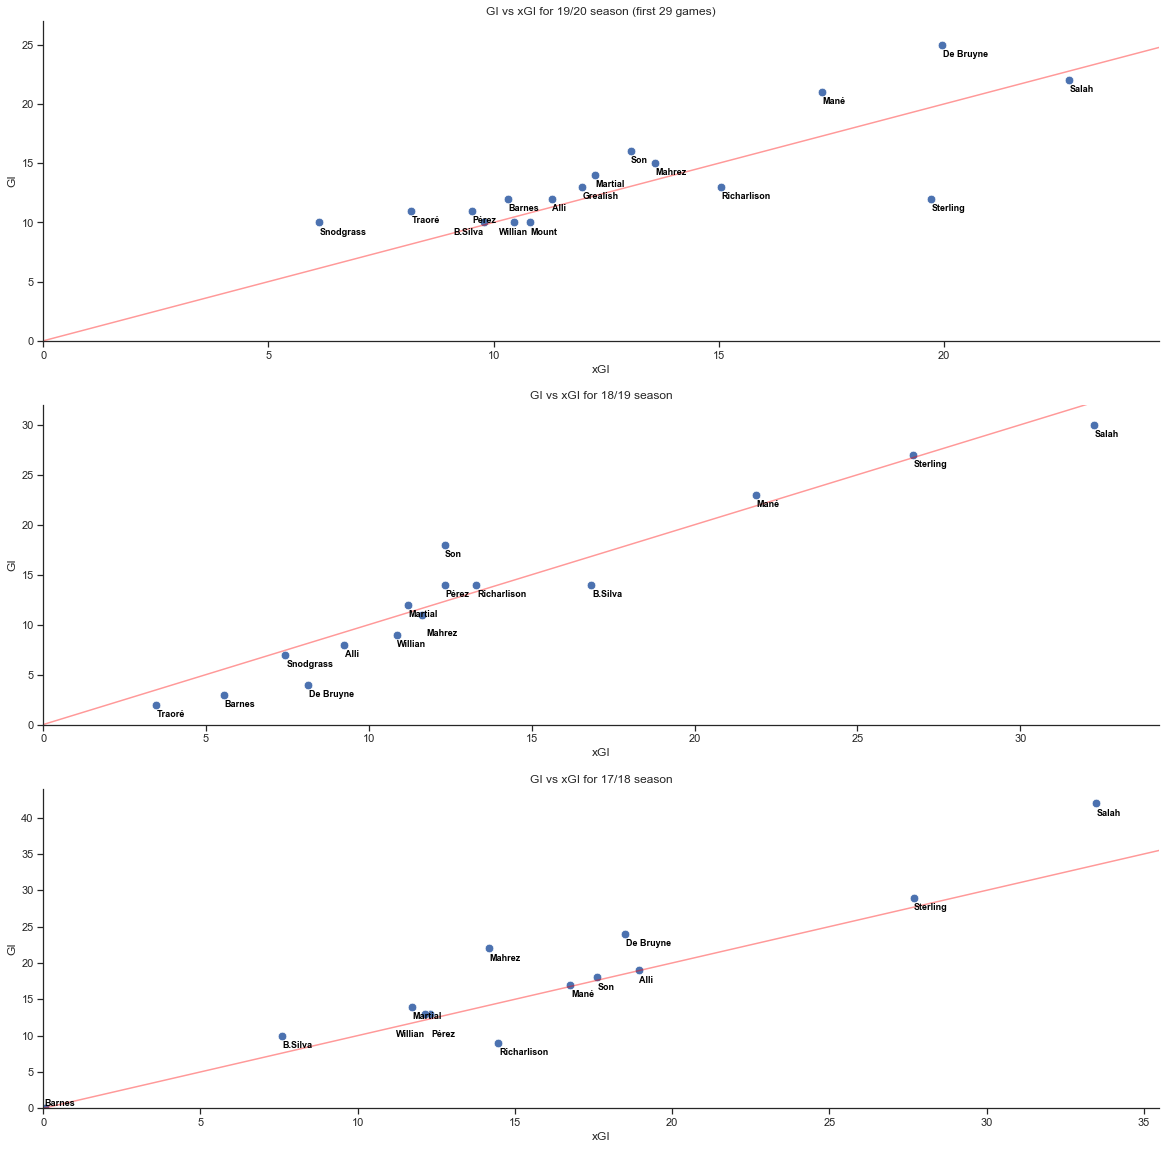

In [53]:
from adjustText import adjust_text
fig, ax = plt.subplots(3, figsize=(20,20))
dfs = [midfielders, _1819_mid, _1718_mid]
for index, df in enumerate(dfs):
    ax[index].set_xlim(0,max(df['xGI'])+2)
    ax[index].set_ylim(0,max(df['GI'])+2)
    sns.lineplot(x=[0,max(max(df['GI']), max(df['xGI']))], y=[0,max(max(df['GI']), max(df['xGI']))], 
                 data=df, color='red', alpha=0.4, ax=ax[index])
    sns.scatterplot(x='xGI', y='GI', data=df, s=75, ax=ax[index])
    sns.despine()
    texts = []
    for row in range(df.shape[0]):
        if len(df.iloc[row]['player_name'].split(' ')) == 2 and df.iloc[row]['player_name'] not in ['Son Heung-Min', 'David Silva', 'Bernardo Silva']:
            texts.append(ax[index].text(df.iloc[row]['xGI'], df.iloc[row]['GI']-0.05*max(df['GI']), df.iloc[row]['player_name'].split(' ')[1],
                            size=9, color='black', weight='semibold')),
            
        elif df.iloc[row]['player_name'] == 'Kevin De Bruyne':
            texts.append(ax[index].text(df.iloc[row]['xGI'], df.iloc[row]['GI']-0.05*max(df['GI']), 'De Bruyne',
                            size=9, color='black', weight='semibold')),
        
        elif df.iloc[row]['player_name'] == 'Son Heung-Min':
            texts.append(ax[index].text(df.iloc[row]['xGI'], df.iloc[row]['GI']-0.05*max(df['GI']), 'Son',
                            size=9, color='black', weight='semibold')),
            
        elif df.iloc[row]['player_name'] == 'Bernardo Silva':
            texts.append(ax[index].text(df.iloc[row]['xGI'], df.iloc[row]['GI']-0.05*max(df['GI']), 'B.Silva',
                            size=9, color='black', weight='semibold'))
            
        else:
            texts.append(ax[index].text(df.iloc[row]['xGI'], df.iloc[row]['GI']-0.05*max(df['GI']), df.iloc[row]['player_name'],
                            size=9, color='black', weight='semibold'))
    
    adjust_text(texts, ax=ax[index])

ax[0].set_title('GI vs xGI for 19/20 season (first 29 games)')
ax[1].set_title('GI vs xGI for 18/19 season')
ax[2].set_title('GI vs xGI for 17/18 season');

This season, De Bruyne and Mané appear to be overperforming based on their stats, but not by that much. Sterling has so far been underperforming his stats, so we may expect some good performances from him in the future.

Another measurement we can make is the likelihood that, if a team scores a goal, a certain player will be directly involved in that goal (i.e. score the goal or provide the assist). Lets join the total goals scored by each players' team to the previous table:  

In [54]:
players_us_GI10 = players_us_GI10.merge(epl_teams[['team', 'scored', 'xG']], left_on='team_title', right_on='team').drop('team',axis=1)
players_us_GI10.rename(columns={'scored':'total_team_goals', 'xG_x': 'xG', 'xG_y':'x_total_team_goals'}, inplace=True)
players_us_GI10['involvement_rate'] = np.round(players_us_GI10['GI']/players_us_GI10['total_team_goals'] * 100,0).astype('int32')
players_us_GI10['x_involvement_rate'] = np.round(players_us_GI10['xGI']/players_us_GI10['x_total_team_goals'] * 100,0).astype('int32')
players_us_GI10

,id,player_name,fpl_name,games,goals,assists,key_passes,npg,npxG,position,...,xG,xGBuildup,xGChain,yellow_cards,GI,xGI,total_team_goals,x_total_team_goals,involvement_rate,x_involvement_rate
0,755,Jamie Vardy,Vardy,26,19,4,16,15,10.433209,F S,...,14.239053,1.447229,13.664330,2,23,17.658717,54,45.359911,43,39
1,770,Ayoze Pérez,Pérez,25,7,4,22,6,5.063555,F M S,...,5.824724,3.150325,10.727269,0,11,9.514788,54,45.359911,20,21
2,6681,Harvey Barnes,Barnes,27,6,6,31,6,7.010123,M S,...,7.010123,5.262268,13.673023,0,12,10.324830,54,45.359911,22,23
3,318,Pierre-Emerick Aubameyang,Aubameyang,26,17,1,20,16,11.240753,F M,...,12.001885,4.388375,15.131196,3,18,15.293150,40,38.410292,45,40
4,3277,Alexandre Lacazette,Lacazette,20,7,3,21,7,6.327157,F S,...,6.327157,1.475994,8.869285,5,10,9.100300,40,38.410292,25,24
5,619,Sergio Agüero,Agüero,22,16,3,19,14,12.665595,F S,...,14.949065,2.522262,16.170626,1,19,17.869274,68,73.078879,28,24
6,618,Raheem Sterling,Sterling,24,11,1,36,11,13.031746,F M S,...,13.792915,8.051197,24.266339,5,12,19.719106,68,73.078879,18,27
7,5543,Gabriel Jesus,Jesus,24,10,4,16,10,13.720686,F S,...,14.481854,4.720705,18.477072,2,14,16.347042,68,73.078879,21,22
8,447,Kevin De Bruyne,De Bruyne,26,9,16,94,9,5.250505,M S,...,5.250505,15.823433,28.985605,2,25,19.951692,68,73.078879,37,27
9,750,Riyad Mahrez,Mahrez,23,7,8,46,7,4.933993,F M S,...,4.933993,9.905799,20.095984,0,15,13.583235,68,73.078879,22,19


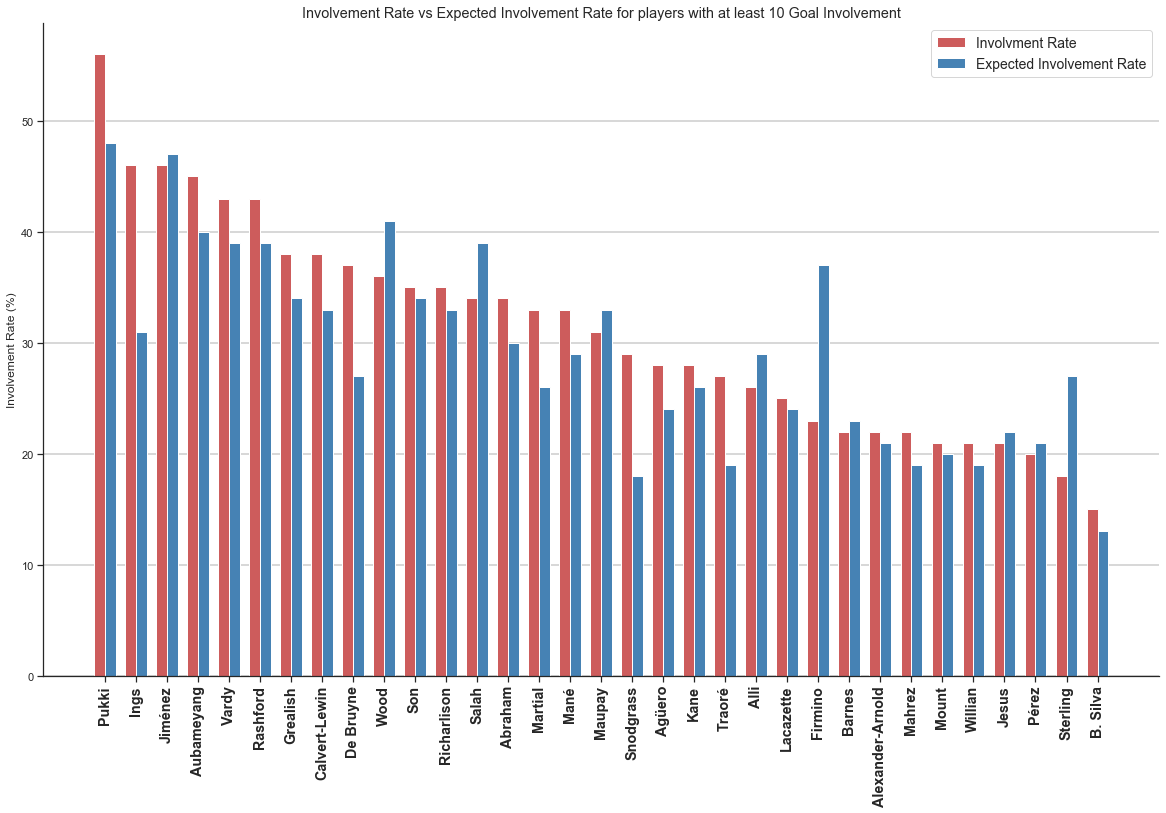

In [55]:
fig, ax = plt.subplots(figsize=(20,12))
temp_data_1 = players_us_GI10.sort_values('involvement_rate', ascending=False)
temp_data_1.reset_index(inplace=True, drop=True)

length = temp_data_1.shape[0]
x = np.arange(length)
x_labels = list(temp_data_1['fpl_name'])
width = 0.35

plt.grid(True, 'major', 'y', linewidth=1.5)
plt.bar(x, height=temp_data_1['involvement_rate'], width=width, color='indianred')
plt.bar(x+width, height=temp_data_1['x_involvement_rate'], width=width, color='steelblue')
ax.set_xticks(x+width/2)
ax.set_xticklabels(x_labels, rotation=90, fontsize='large', weight='semibold')
ax.set_ylabel('Involvement Rate (%)')
ax.legend(['Involvment Rate', 'Expected Involvement Rate'], prop={'size': 14})
sns.despine()
ax.set_title('Involvement Rate vs Expected Involvement Rate for players with at least 10 Goal Involvement', fontsize='large');

This graph shows a players' involvement rate and expected involvement rate. Players towards the left of the graph are the ones on which their clubs are most reliant, though in some cases there is a big difference between the expected value and the actual value, so we may consider their current involvement to be unsustainable. On the other hand, there are a few players who currently have less involvement than stats would predict. The most extreme cases, Sterling and Firmino, were also identified as underperfomers when we compared GI to xGI above.

This stat alone would suggest that the players with higher rates are the ones most likely to perform well, however it does not consider the overall strength of the team which they play for. Lets use a new statistic which accounts for both individual and team performance, measured relative to the highest rated players:

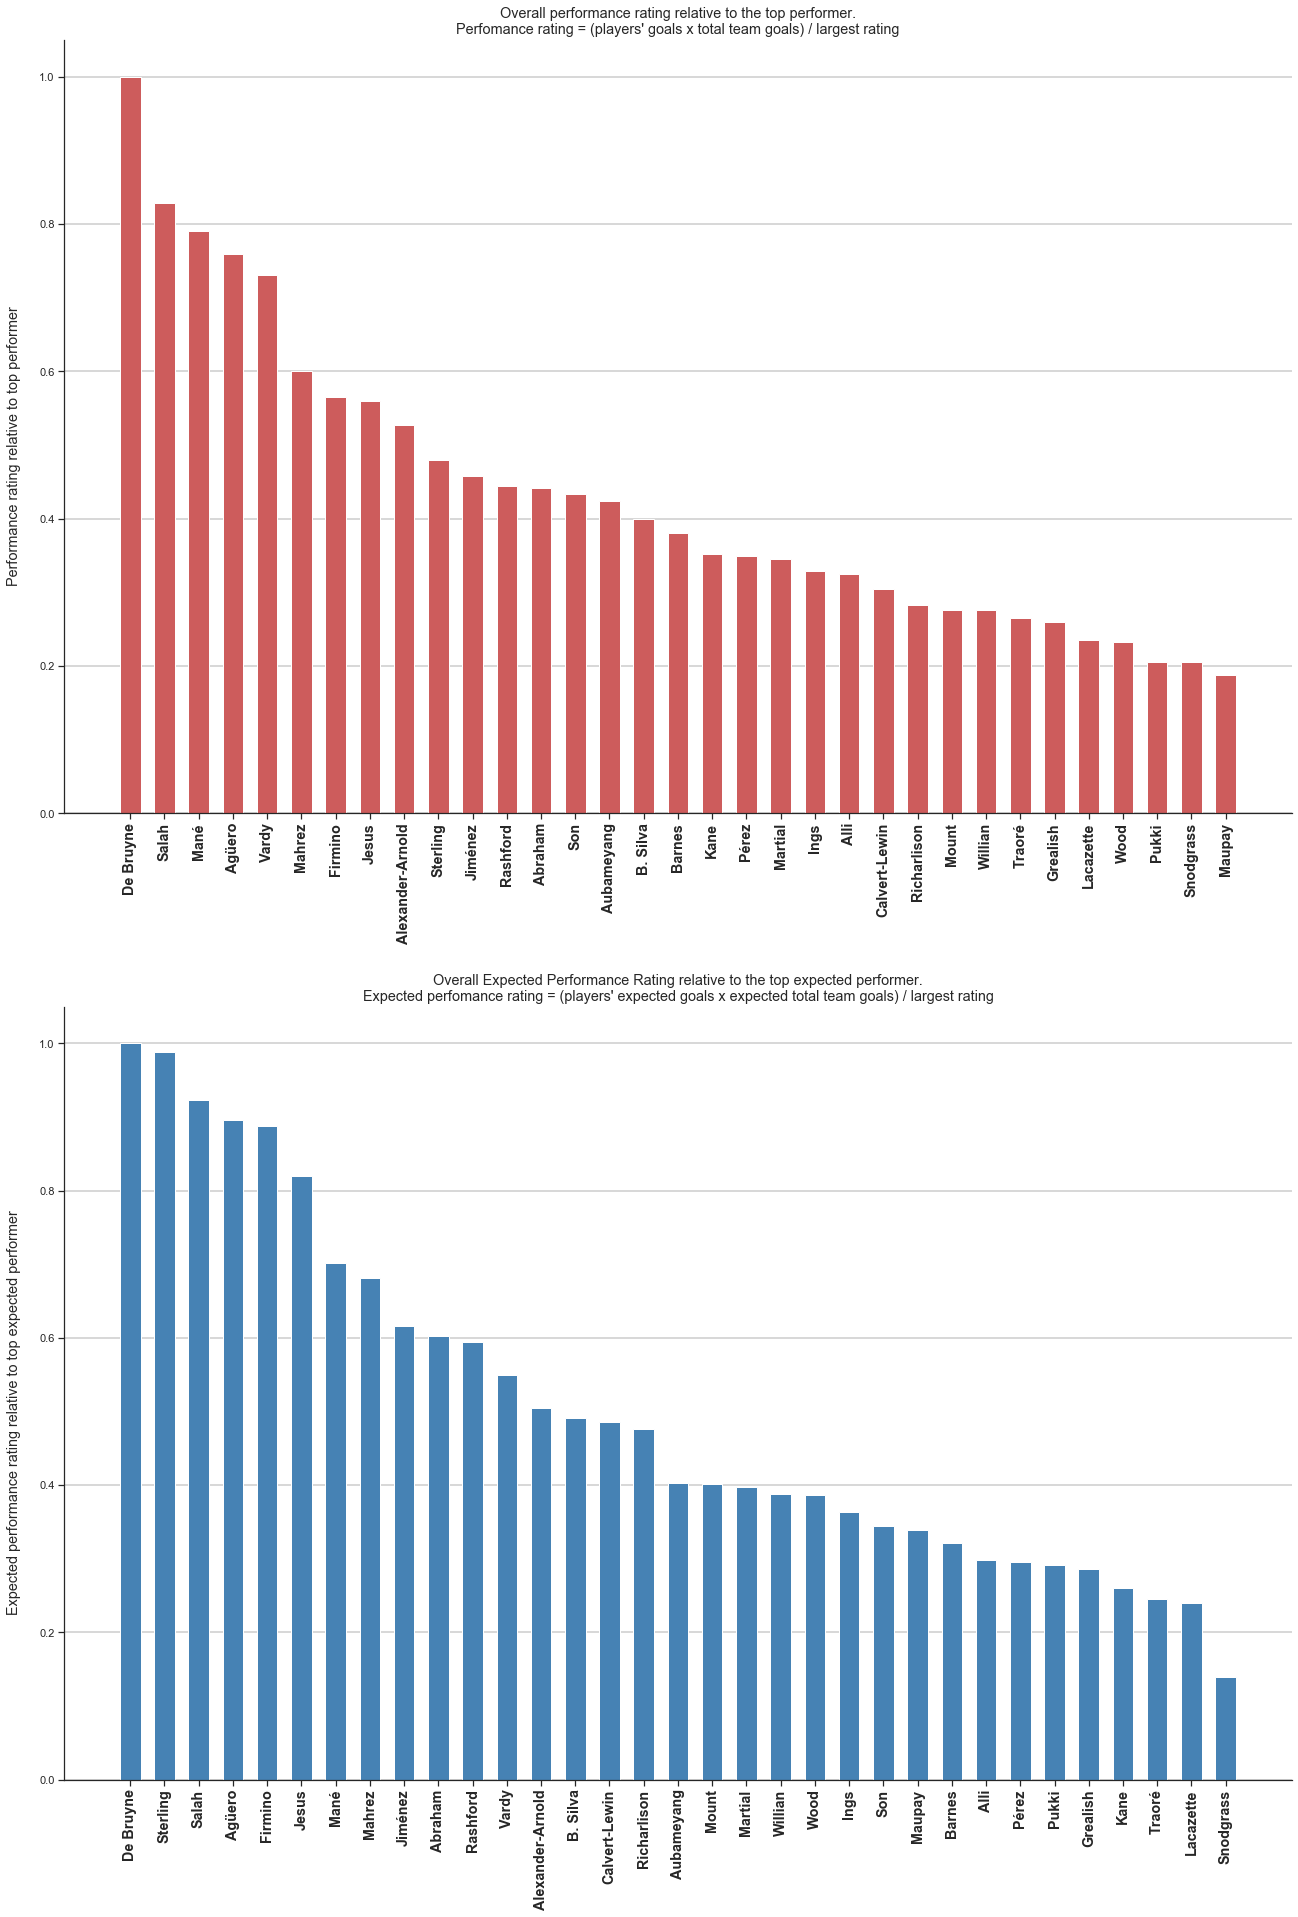

In [56]:
players_us_GI10['performance_rating'] = players_us_GI10['GI'] * players_us_GI10['total_team_goals']
players_us_GI10['x_performance_rating'] = players_us_GI10['xGI'] * players_us_GI10['x_total_team_goals']
players_us_GI10['performance_rating'] = (players_us_GI10['GI'] * players_us_GI10['total_team_goals']) / max(players_us_GI10['performance_rating'])
players_us_GI10['x_performance_rating'] = (players_us_GI10['xGI'] * players_us_GI10['x_total_team_goals']) / max(players_us_GI10['x_performance_rating'])

temp_data_2 = players_us_GI10.sort_values('performance_rating', ascending=False)
temp_data_2.reset_index(inplace=True)

temp_data_3 = players_us_GI10.sort_values('x_performance_rating', ascending=False)
temp_data_3.reset_index(inplace=True)

fig, ax = plt.subplots(2, figsize=(22,32))
length = temp_data_2.shape[0]
x = np.arange(length)
x_labels_2 = list(temp_data_2['fpl_name'])
x_labels_3 = list(temp_data_3['fpl_name'])
sns.despine()
ax[0].grid(True, 'major', 'y', linewidth=1.5)
ax[1].grid(True, 'major', 'y', linewidth=1.5)

plt.grid(True, 'major', 'y', linewidth=1.5)
ax[0].bar(x, height=temp_data_2['performance_rating'], width=0.6, color='indianred')
ax[0].set_xticks(x)
ax[0].set_xticklabels(x_labels_2, rotation=90, fontsize='large', weight='semibold')
ax[0].set_ylabel('Performance rating relative to top performer', fontsize='large')
ax[0].yaxis.set_label_coords(-0.035,0.475)
ax[0].set_title('Overall performance rating relative to the top performer.\n' 
                'Perfomance rating = (players\' goals x total team goals) / largest rating', fontsize='large')

ax[1].bar(x, height=temp_data_3['x_performance_rating'], width=0.6, color='steelblue')
ax[1].set_xticks(x)
ax[1].set_xticklabels(x_labels_3, rotation=90, fontsize='large', weight='semibold')
ax[1].set_ylabel('Expected performance rating relative to top expected performer', fontsize='large')
ax[1].yaxis.set_label_coords(-0.035,0.475)
ax[1].set_title('Overall Expected Performance Rating relative to the top expected performer.\n' 
                'Expected perfomance rating = (players\' expected goals x expected total team goals) / largest rating', fontsize='large')

plt.subplots_adjust(hspace=0.25);

These graphs give us a better idea of which players have the best combination of both individual and team performances. We see that the majority of the top performers in the previous graph score far lower when we take into account their team's overall performance, for example Pukki who ranked third in the above graph, but fifth from the bottom in this one. In comparison, Manchester City players, for example Agüero and De Bruyne, scored lower in involvement rate but high in overall performance, due to the high volume of chances Manchester City create.

As we have identified before, we see that Sterling is underperforming expectations when looking at the second plot, however we can now also see that despite this he still scores relatively high on actual performance. Also of note is Alexander-Arnold, a defender, who is outperforming many players in attacking output in both the expected and actual metrics. 

One factor we have not taken into account for FPL is each players price in the game. In general we cant just select all of the top performing players for their team as this will usually go over budget. Lets consider how each player is performing relative to their in-game price:

In [57]:
players_prices = pd.merge(players_us_GI10, fpl[['name', 'team', 'cost']], left_on='fpl_name', right_on='name', how='left')
players_prices.at[11, 'cost'] = 7.8
players_prices.drop(2, axis=0, inplace=True)
players_prices.drop(['name', 'team'], axis=1, inplace=True)

players_prices['price_rating'] = (players_prices['performance_rating'] / players_prices['cost']) * 10
players_prices['x_price_rating'] = (players_prices['x_performance_rating'] / players_prices['cost']) * 10
players_prices.sort_values('price_rating', inplace=True, ascending=False)

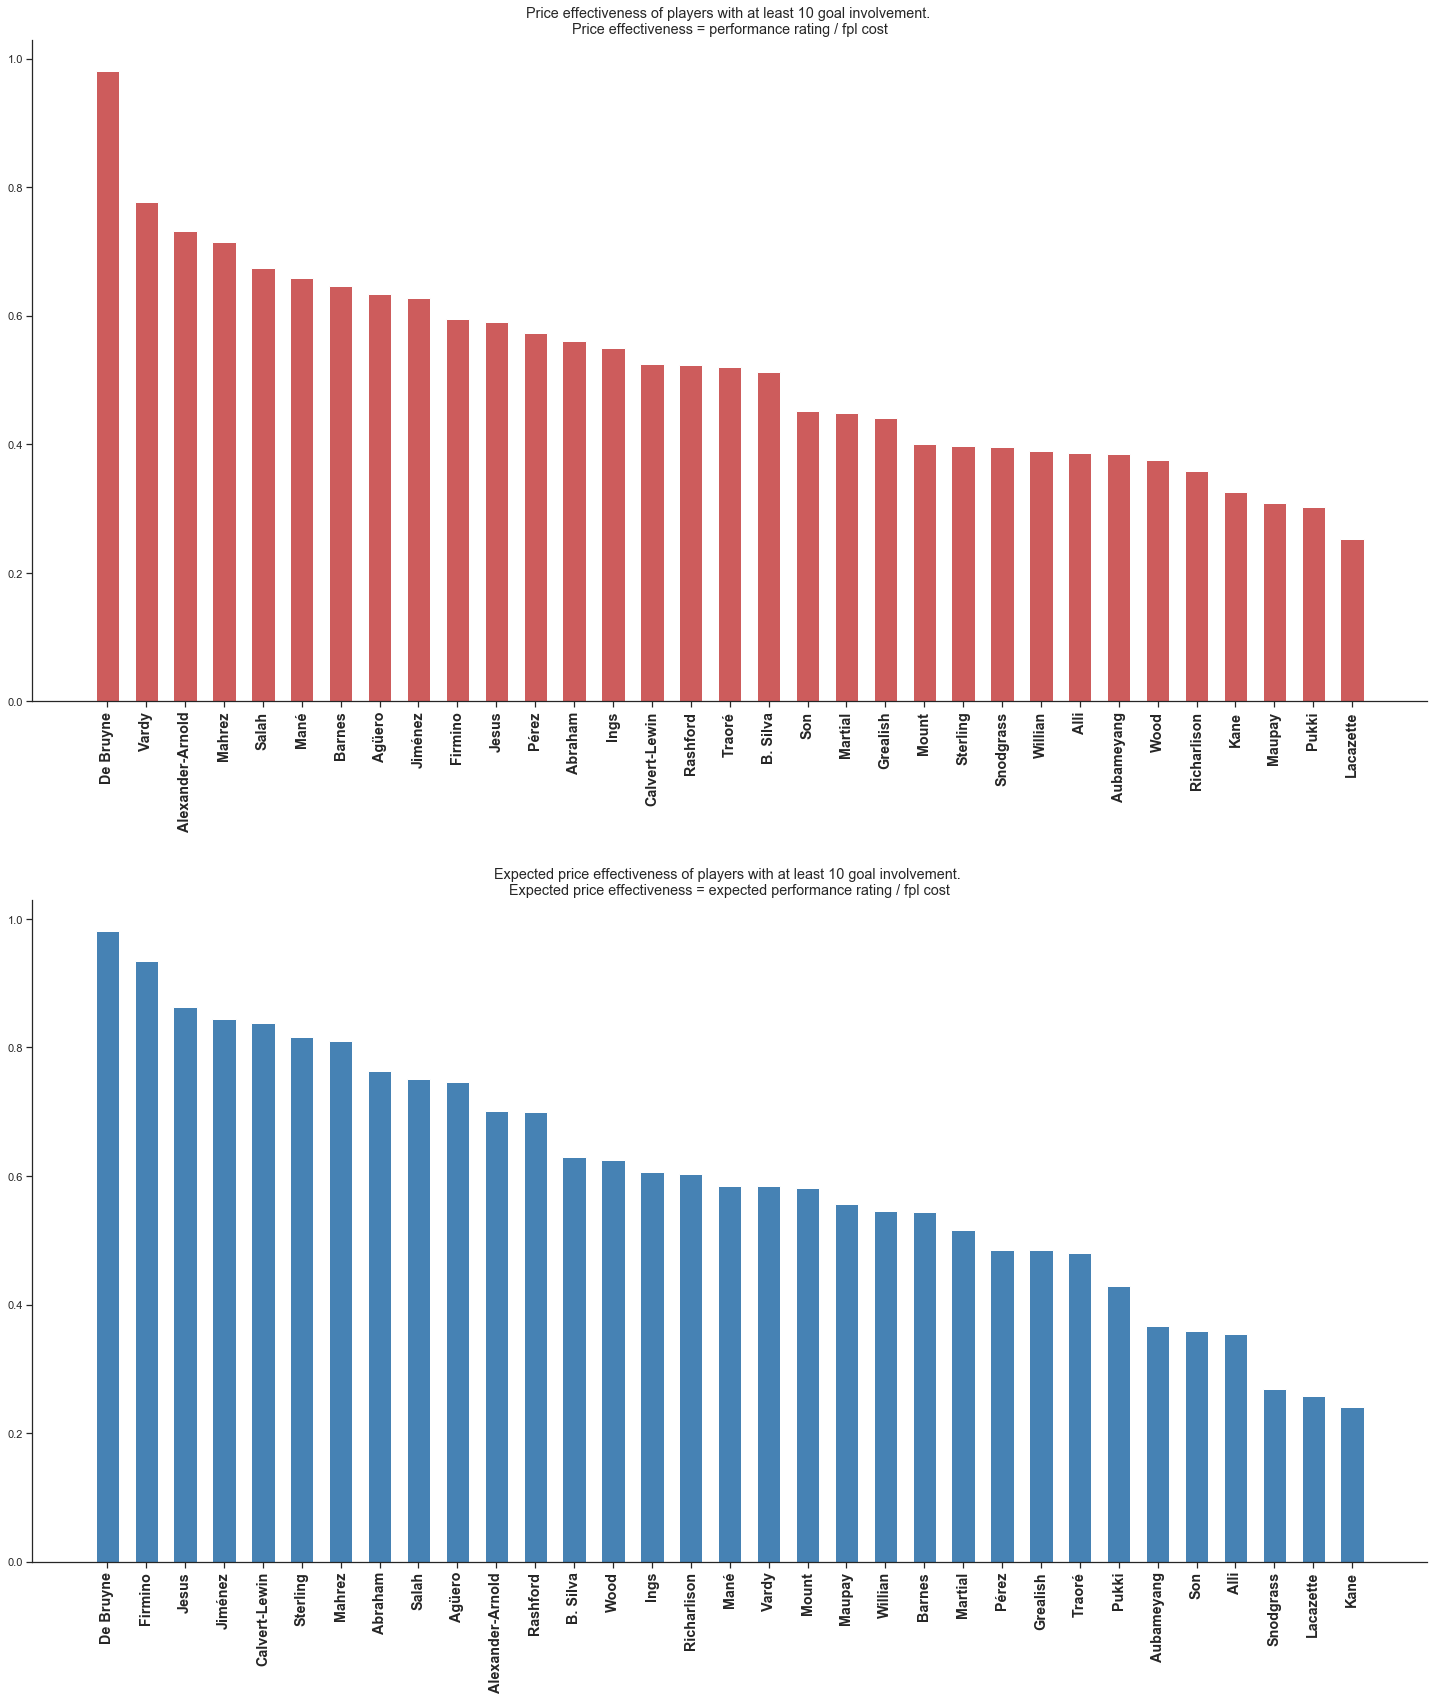

In [58]:
fig, ax = plt.subplots(2, figsize=(25,28))
length = players_prices.shape[0]
x = np.arange(length)
sns.despine()
plt.subplots_adjust(hspace=0.3)

temp_data_4 = players_prices.sort_values('x_price_rating', ascending=False)

x_labels_4 = list(players_prices['fpl_name'])
x_labels_5 = list(temp_data_4['fpl_name'])

ax[0].bar(x, players_prices['price_rating'], data=players_prices, width=0.6, color='indianred')
ax[0].set_xticks(x)
ax[0].set_xticklabels(x_labels_4, rotation=90, fontsize='large', weight='semibold')
ax[0].set_title('Price effectiveness of players with at least 10 goal involvement. \n'
                'Price effectiveness = performance rating / fpl cost', fontsize='large')

ax[1].bar(x, temp_data_4['x_price_rating'], data=temp_data_4, width=0.6, color='steelblue')
ax[1].set_xticks(x)
ax[1].set_xticklabels(x_labels_5, rotation=90, fontsize='large', weight='semibold')
ax[1].set_title('Expected price effectiveness of players with at least 10 goal involvement. \n'
                'Expected price effectiveness = expected performance rating / fpl cost', fontsize='large');

When price is factored in, many players' rankings change by a significant amount. Aubameyang, who ranks near the middle of our original performance statistics, now find himself near the bottom of the list due to his high cost compared to other players. Other expensiver players such as Sterling and Agüero also fall a few places. On the other hand, De Bruyne remains at the top despite his relatively high cost, and is by far the most cost-efficient player to own.